In [2]:
%load_ext autoreload
%autoreload 2

In [154]:
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import pytorch_lightning as pl
from torchinfo import summary
from sklearn.model_selection import train_test_split

from lstm_model_behavior import RecurrentAutoencoder
from lin_ae_model_behavior import LinearAutoencoder, LinearVariationalAutoencoder
from utils import (plot_reach, train_model, plot_reconstruction_examples,
                   plot_examples_based_on_latent_space, plot_data_in_latent_space,
                   plot_examples_from_class)

plt.rcParams['figure.dpi'] = 100

In [3]:
PATH_ROOT = Path('/Volumes/GoogleDrive/My Drive/NMA-22/naturalistic_arm_movements_ecog')
PATH_DATA = PATH_ROOT / 'data' / 'behavior_data'

SEED = 42
pl.seed_everything(SEED)

DTYPE = torch.float
DEVICE = torch.device("mps")

DATASET = np.load(PATH_DATA / "reaches_scales.npy")
DATASET = np.swapaxes(DATASET, 2, 1)[:, :75, :]

PATH_ROI = PATH_ROOT / "data" / "Naturalistic reach ECoG tfrs ROI"
METADATA = pd.read_csv(PATH_ROI / "power-roi-all-patients-metadata.csv", index_col=0)

# check the dataset shape
assert DATASET.shape == (5984, 75, 2)

Global seed set to 42


### Prepare data

In [4]:
X_train, X_test = train_test_split(DATASET, test_size=0.2, random_state=SEED)

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=SEED)

X_train = torch.tensor(X_train, device=DEVICE, dtype=DTYPE)
X_test = torch.tensor(X_test, device=DEVICE, dtype=DTYPE)
X_val = torch.tensor(X_val, device=DEVICE, dtype=DTYPE)

# stack coordinates
X_train = torch.swapaxes(X_train, 2, 1).view(X_train.size(0), -1)
X_test = torch.swapaxes(X_test, 2, 1).view(X_test.size(0), -1)
X_val = torch.swapaxes(X_val, 2, 1).view(X_val.size(0), -1)

assert X_train.shape == (3829, 150)

In [5]:
import ipywidgets

def plot_reaches_widget(event):
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_reach(ax, DATASET, event)
    plt.show();

ipywidgets.interact(
    plot_reaches_widget, event=ipywidgets.IntSlider(
    min=0, max=DATASET.shape[0]-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='event', max=5983), Output()), _dom_classes=('widget-inte…

### Train models

### Linear VAE

### Linear AE

In [37]:
lae = LinearAutoencoder(150, n_hidden=5)
summary(lae, (1, 150), col_names=["input_size", "output_size", "num_params"]) 

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LinearAutoencoder                        [1, 150]                  [1, 150]                  --
├─Sequential: 1-1                        [1, 150]                  [1, 5]                    --
│    └─Linear: 2-1                       [1, 150]                  [1, 40]                   6,040
│    └─ReLU: 2-2                         [1, 40]                   [1, 40]                   --
│    └─Linear: 2-3                       [1, 40]                   [1, 20]                   820
│    └─ReLU: 2-4                         [1, 20]                   [1, 20]                   --
│    └─Linear: 2-5                       [1, 20]                   [1, 5]                    105
├─Sequential: 1-2                        [1, 5]                    [1, 150]                  --
│    └─Linear: 2-6                       [1, 5]                    [1, 20]                   120
│    └─ReLU: 2-7             

In [38]:
train_model(
    lae, X_train, X_val, X_test, n_epochs=30, batch_size=20, 
    add_to_log_name=['n_latent', 'lr'])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.0 K 
1 | decoder | Sequential | 7.1 K 
---------------------------------------
14.1 K    Trainable params
0         Non-trainable params
14.1 K    Total params
0.056     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.006285373587161303
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


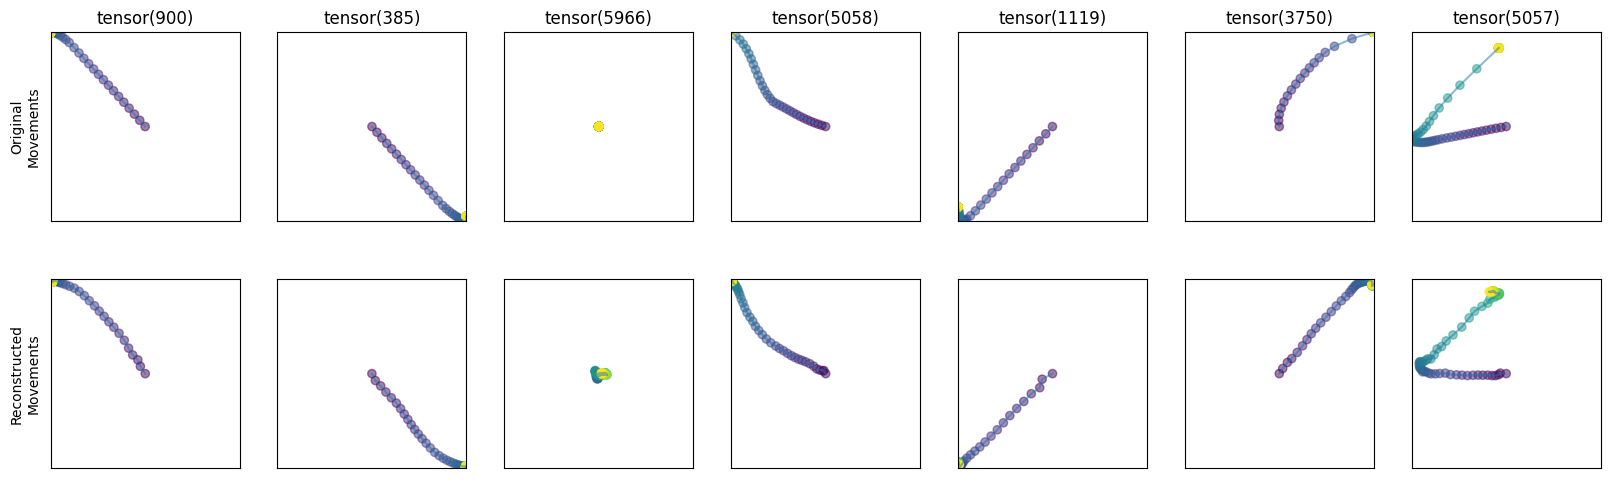

In [45]:
plot_reconstruction_examples(lae, DATASET, 7)

### Linear VAE

In [142]:
lvae = LinearVariationalAutoencoder(150, n_latent=2)

# summary(lvae, (1, 150), col_names=["input_size", "output_size", "num_params"]) 

In [143]:
train_model(
    lvae, X_train, X_val, X_test, n_epochs=30, batch_size=20, 
    add_to_log_name=['n_latent', 'lr'])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/LinearVariationalAutoencoder_n_latent=2_lr=0.005

  | Name        | Type       | Params
-------------------------------------------
0 | encoder     | Sequential | 28.6 K
1 | decoder     | Sequential | 28.8 K
2 | fc_mu       | Linear     | 34    
3 | fc_var      | Linear     | 34    
4 | decoder_inp | Linear     | 48    
-------------------------------------------
57.5 K    Trainable params
0         Non-trainable params
57.5 K    Total params
0.230     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.035139694809913635
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


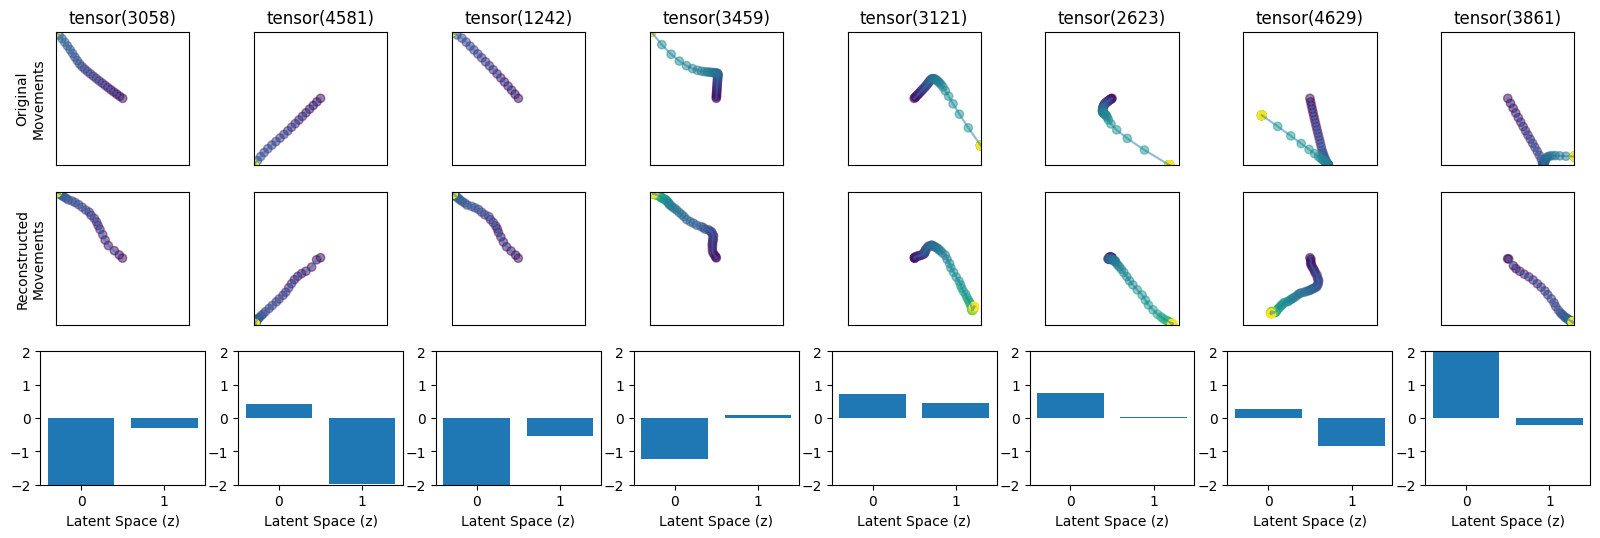

In [144]:
plot_reconstruction_examples(lvae, DATASET, 8, True)

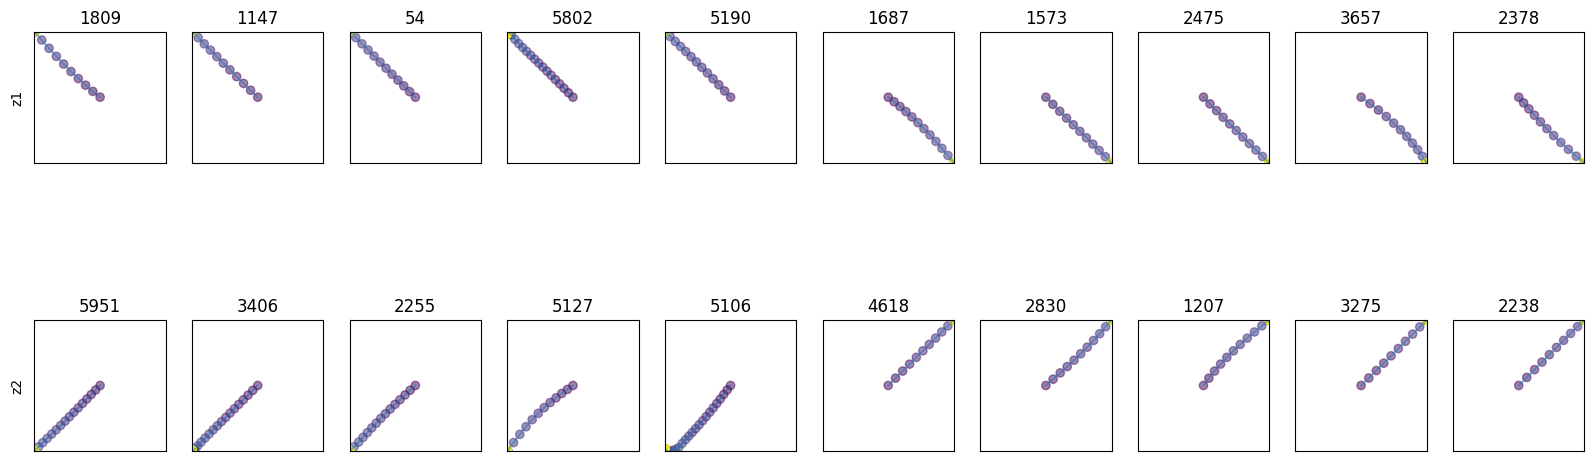

In [145]:
plot_examples_based_on_latent_space(lvae, DATASET)

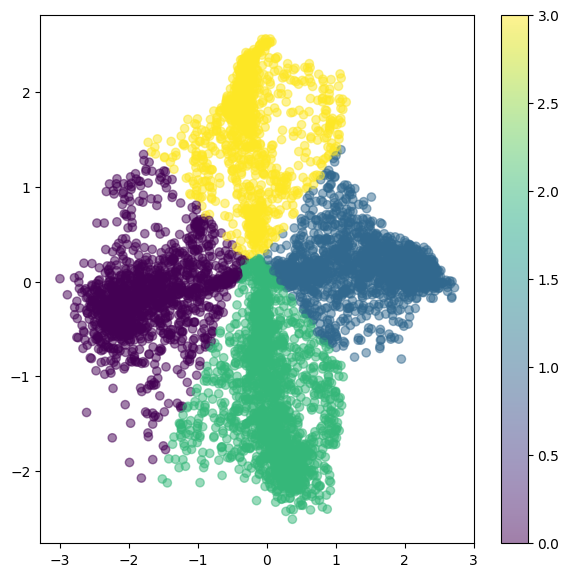

In [153]:
labels = plot_data_in_latent_space(lvae, DATASET, 4)

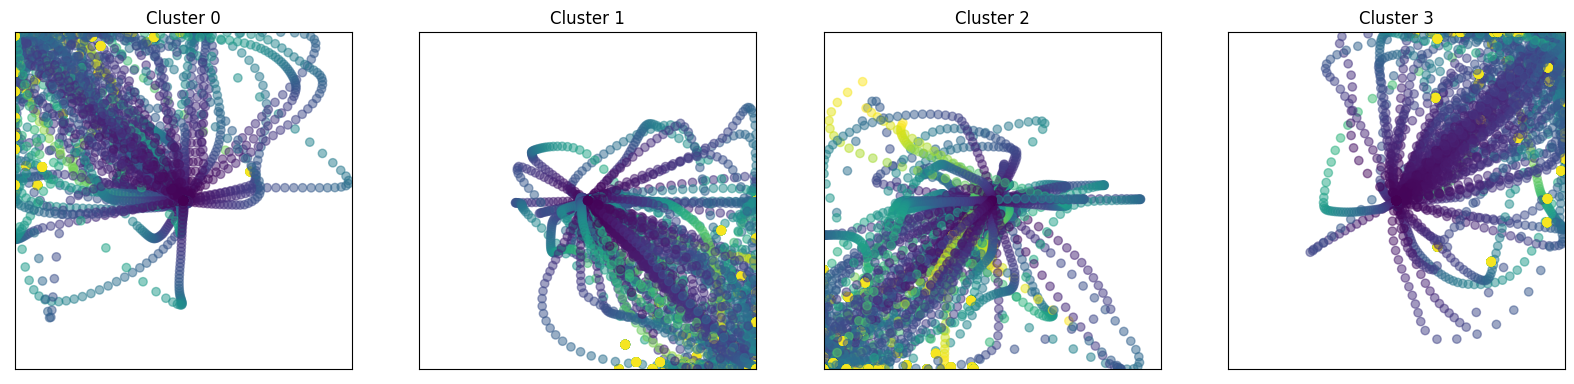

In [159]:
plot_examples_from_class(labels, DATASET, 100)